In [484]:
import requests
import math
import io
import imutils

def slope(x, y):
    sl = math.sqrt(x**2 + y**2)
    return sl

def get_ann(img_path,api_url) -> dict:
    ''' img_path : str or PIL image '''
    if type(img_path) == str:
        file_dict = {"file": open(img_path  , "rb")}
    else:
        output = io.BytesIO()
        image = img_path
        image.save(output, format="JPEG")
        file_dict = {"file": output.getvalue()}
    # headers = {"secret": "Boostcamp0000"}
    headers = {"secret": "Boostcamp0001"}
    response = requests.post(api_url, headers=headers, files=file_dict)
    return response.json()


def get_degree(annos):

    # 제일 대표적인 bbox를 찾음
    horizontal_list = []

    for idx, anno in enumerate(annos):
        xlen = anno['points'][1][0] - anno['points'][0][0] # x축 길이 차
        ylen = anno['points'][0][1] - anno['points'][1][1] # y축 길이 차
        ylen = abs(ylen)
        xlen2 = anno['points'][2][0] - anno['points'][1][0] # x축 길이 차
        xlen2 = abs(xlen2)
        ylen2 = anno['points'][1][1] - anno['points'][2][1] # y축 길이 차
        ylen2 = abs(ylen2)
        horizontal_list.append((slope(xlen,ylen)/slope(xlen2,ylen2), idx, anno["text"],xlen,ylen))

    longest = max(horizontal_list)[1]
    # for i in horizontal_list:
    #     print(i)
    print(annos[longest])

    # 각도 계산
    thetaplus = False
    xlen = annos[longest]['points'][1][0] - annos[longest]['points'][0][0]
    ylen = annos[longest]['points'][0][1] - annos[longest]['points'][1][1] # 음수일 수도 있음

    if ylen < 0 :
        thetaplus = True
        ylen = abs(ylen)

    costheta = xlen / slope(xlen, ylen)
    theta = math.acos(costheta)
    degree = round(theta * 57.29,1)

    if thetaplus == True:
        degree = degree
    else:
        degree = -degree

    return degree

In [485]:
# path = '../Data set/real data/general/general222.jpg'
path = '/opt/ml/upstage_OCR/Data set/real data/receipt/receipt066.jpg' 
# path = '/opt/ml/upstage_OCR/code/test set/xxx2.jpg' 

# y축 tmp 합치기 예시
# 제너렐 216

# x축 tmp 합치기 예시

# 돌리면서 ocr 이상해진 애들
# receipt 28

# 영수증
# 대형이미지 000
# 휜거 003
# 006 
# 008
# 010

# ann_dict = get_ann(path, "http://118.222.179.32:30000/ocr/")
ann_dict = get_ann(path, "http://118.222.179.32:30001/ocr/")
# ann_dict
annos = ann_dict['ocr']['word']

# annos
degree = get_degree(annos)
degree

{'points': [[124, 243], [258, 235], [259, 248], [124, 256]], 'orientation': 'Horizontal', 'text': '세이보리포테이토스틱'}


-3.4

In [486]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import albumentations as A
from PIL import Image
from imageio import imread

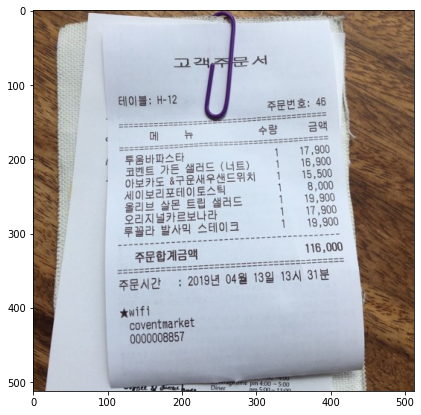

In [487]:
image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(7,7))
plt.imshow(image)
pil_image = Image.fromarray(image)

In [488]:
from PIL import ImageOps, Image, ImageDraw, ImageFont
from itertools import chain

In [489]:
def draw_polygon(img: Image, pts, tags,tag_ori):
    """이미지에 폴리곤을 그린다. illegibility의 여부에 따라 라인 색상이 다르다."""
    img_draw = ImageDraw.Draw(img)

    font = ImageFont.truetype('/opt/ml/upstage_OCR/tools/fonts/NanumSquareRoundB.ttf',size=int(img.height/38))
    # img_draw.rectangle([(pts[0][0],pts[0][1]-20),(pts[0][0]+200,pts[0][1]-20+20)], fill='yellow')
    img_draw.text((pts[0][0],pts[0][1]-int(img.height/38)),tags,(0,0,0),font,align='left')

    pts = list(chain(*pts)) + pts[0]  # flatten 후 첫번째 점을 마지막에 붙인다.
    # 폴리곤 선 너비 지정이 안되어 line으로 표시
    img_draw.line(pts, width=3, fill=(0, 255, 255) if tag_ori == 'Horizontal' else (255,0,0))


In [490]:
def read_img(img, target_h: int = 1000) -> Image:
    """이미지 로드 후 텍스트 영역 폴리곤을 표시하여 반환한다."""
    # load image, annotation
    # img = Image.open(path)
    # img = ImageOps.exif_transpose(img)  # 이미지 정보에 따라 이미지를 회전

    # ann_dict = get_ann(img, "http://118.222.179.32:30000/ocr/")
    ann_dict = get_ann(img, "http://118.222.179.32:30001/ocr/")

    # resize
    h, w = img.height, img.width
    ratio = target_h/h
    target_w = int(ratio * w)
    # img = img.resize((target_w, target_h))

    # draw polygon
    for val in ann_dict['ocr']['word']:
        poly = val['points']
        tag_ori = val['orientation']
        tag_text = val["text"]
        poly_resize = [[v for v in pt] for pt in poly]
        draw_polygon(img, poly_resize, tag_text, tag_ori)

    return img

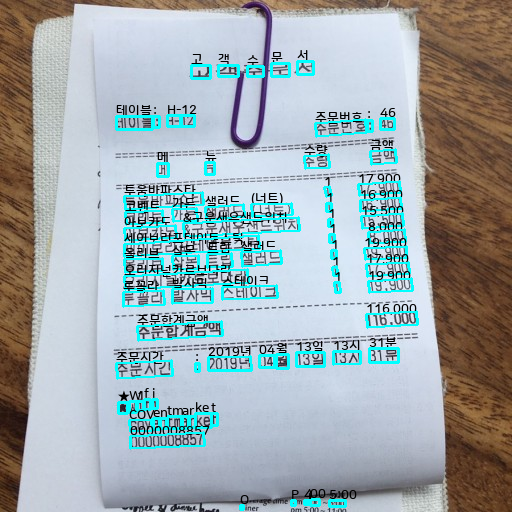

In [491]:
read_img(pil_image)
# plt.figure(figsize=(15,15))
# plt.imshow(read_img(pil_image))

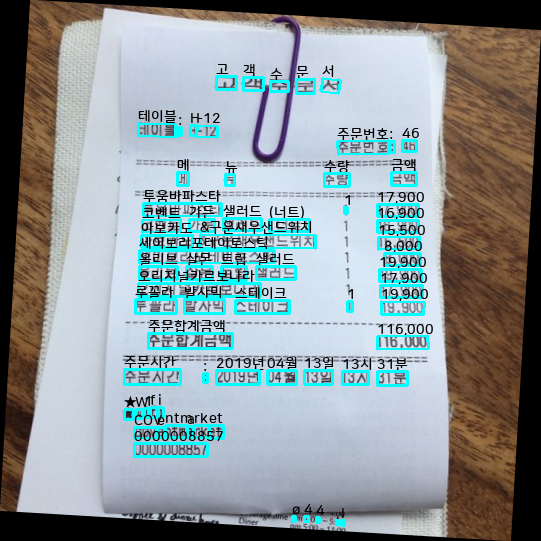

In [492]:
rotated = imutils.rotate_bound(image, -degree)
pil_rotate=Image.fromarray(rotated)
read_img(pil_rotate)

In [493]:
# import matplotlib.pyplot as plt
# import os 

# folder_path = '/opt/ml/upstage_OCR/Data set/real data/receipt'
# imagelist = sorted(os.listdir(folder_path))
# imagelist = imagelist[:10]

# for idx, path in enumerate(imagelist):
#     imgpath = os.path.join(folder_path, path)
#     image = cv2.imread(imgpath)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     pil_image = Image.fromarray(image)
#     ann_dict = get_ann(imgpath, "http://118.222.179.32:30001/ocr/")
#     annos = ann_dict['ocr']['word']
#     degree = get_degree(annos)
#     rotated = imutils.rotate_bound(image, -degree)
#     pil_rotate=Image.fromarray(rotated)
#     plt.figure(figsize=(50,50))
#     plt.subplot(1,2, 1)
#     plt.imshow(read_img(pil_image) )
#     plt.subplot(1,2, 2)
#     plt.imshow(read_img(pil_rotate) )
#     plt.show()

In [494]:
# func_list = [
#     A.Rotate(p=1.0, limit=[degree,degree],
#     border_mode= cv2.BORDER_CONSTANT
#     ),
# ]

# alb_transform = A.Compose(func_list)

# transformed = alb_transform(image=image)

# pil_image=Image.fromarray(transformed["image"])
# plt.figure(figsize=(7,7))
# plt.imshow(transformed["image"])

In [495]:
pil_rotate2=Image.fromarray(rotated)
# ann_dict2 = get_ann(pil_rotate2,"http://118.222.179.32:30000/ocr/")
ann_dict2 = get_ann(pil_rotate2,"http://118.222.179.32:30001/ocr/")
annos2 = ann_dict2['ocr']['word']
degree2 = get_degree(annos2)
degree2

{'points': [[139, 250], [274, 250], [274, 262], [139, 263]], 'orientation': 'Horizontal', 'text': '세이보리포테이토스틱'}


-0.0

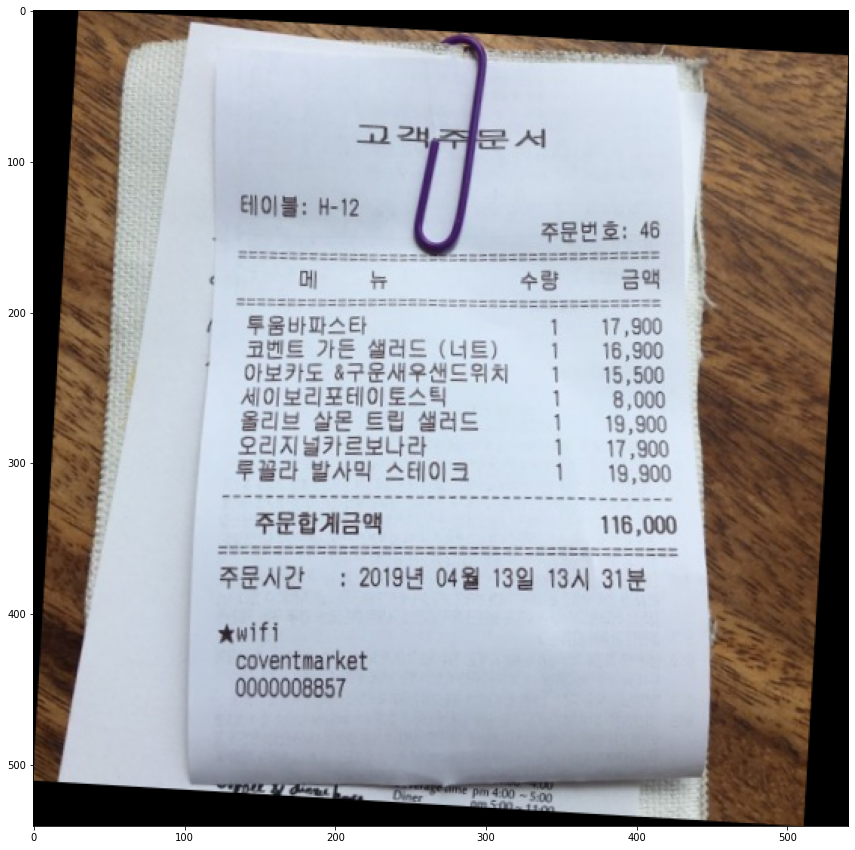

In [496]:
pil_rotate2
plt.figure(figsize=(15,15))
plt.imshow(pil_rotate2)

In [497]:

texts = []
for ind, anno in enumerate(annos2):
  # print((ind, anno['points'][0],anno['points'][1],anno['points'][2],anno['points'][3], anno['text']))
  texts.append((ind, anno['points'][0],anno['points'][1], anno['text'], anno['points'][2],anno['points'][3],)) 

texts_ = sorted(texts, key = lambda x: (x[1][1],x[1][0]))  # y로 정렬 후 x정렬

# for i in texts_:
#   print(i)

tmp = texts_[0][1][1] # 첫번째 글자의 y좌표 
align = []
phase = []
for text in texts_:
  new_phase = []
  if abs(max(text[1][1],text[2][1]) - tmp) <= ((text[5][1] - text[1][1])/1.5) :  #  같은 라인 판별 / 글자의 반 이내면 
    phase.append(text)
    tmp = min(text[2][1], text[1][1])
  else: # tmp값 벌어지면 다음 라인 취급
    phase.sort(key = lambda x: x[1][0]) # x로 정렬
    align.append(phase)
    new_phase.append(text)
    phase = new_phase
    tmp = min(text[2][1], text[1][1])

phase.sort(key = lambda x: x[1][0])
align.append(phase) # 마지막 줄 추가


for i in align:
      for n in i:
          print(n[3] ,end="  ")
      print(" ") 

# print("--------------------")
# for i in align:
#   oneline = ""
#   for n in i:
#     oneline = oneline + n[3]
#   print(oneline)


# print("--------------------")
# line = []
# word = []
# for i in align:
#     tmp = i[0][1][0]
#     for n in i:
#       if n[1][0] - tmp <= ((n[2][0]-n[1][0])/len(n[3]))/1.5: 
#         word.append(n[3])
#         tmp = n[2][0]
#       else:
#         word.append(" ")
#         word.append(n[3])
#         tmp = n[2][0]
#     line.append(word)
#     word = []

# for i in line:
#   s = "".join(i)
#   print(s)



고  객  수  문  서   
테이블  :  H  -12   
주문번호  :  46   
메  뉴  수량  금액   
투움바파스타  1  17,900   
코벤트  가든  샐러드  (너트)  16,900   
아보카도  &구운새우샌드위치  15,500   
세이보리포테이토스틱  8,000   
올리브  살몬  트립  샐러드  19,900   
오리지널카르보나라  17,900   
루꼴라  발사믹  스테이크  1  19,900   
주문합계금액  116,000   
주문시간  :  2019년  04월  13일  13시  31분   
★  W  1  f  i   
COV  e  ntm  a  rk  et   
0000008857   
ø  4  4   
.  I   


In [498]:
# 한줄 
# if id pw in line 
#    비밀번호 비번 pw p/w password 


# general receipt image claasification 


In [499]:
# 0 other
# 1 id
# 2 pw 
# 3 other info(화장실, 인스타)
